# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

In [1]:
"""
1 : calibration de la camera
2 : par cette calibration, on peut récupérer les matrices de rotations et de translations correspondantes pour chaque image 


1 : trouver les matrices projections correspondantes des deux camera P et P' (par calibration de caméra) 
On a mis une ligne rouge sur l'objet avant de prendre des paires de photos (gauche et droite)
2 : on peut determiner la matrice fondamentale a partir à partir de P et P', la matrice fondamentale F permet de trouver la ligne épipolaire (sur l'image de droite) correspondante à un point de l'image de gauche 

Avant de prendre les deux photos des cameras, on trace une ligne rouge sur l'objet qui va permettre de faciliter la correspondances entre un point et sa ligne épipolaire
draw_epilines() dans open cv
"""

import numpy as np
from numpy.linalg import inv
import cv2 
import glob
from matplotlib import pyplot as plt

# Loading the chessboard images
chessboardRight = glob.glob('chessboards/c*Right.png')
chessboardLeft = glob.glob('chessboards/c*Left.png')

# Loading the scan images
scanRight = glob.glob('scanRight/*.png')
scanLeft = glob.glob('scanLeft/*.png')



criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:7].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

grayShape = cv2.cvtColor(cv2.imread(chessboardRight[0]), cv2.COLOR_BGR2GRAY).shape[::-1]


# calibrating left images 
for image in chessboardLeft:
    img = cv2.imread(image)
    grayL = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayL, (7,7), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners = cv2.cornerSubPix(grayL,corners, (11,11), (-1,-1), criteria)
        imgpointsL.append(corners)
        # cv2.drawChessboardCorners(img, (7,7), corners, ret)


# calibrating right images 
for image in chessboardRight:
    img = cv2.imread(image)
    grayR = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(grayR, (7,7), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners = cv2.cornerSubPix(grayR, corners, (11,11), (-1,-1), criteria)
        imgpointsR.append(corners)
        cv2.drawChessboardCorners(img, (7,7), corners, ret)


        
# cv2.destroyAllWindows()
ret, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayShape, None, None)
ret, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayShape, None, None)



ret, mtxL, distL, mtxR, distR, R, T, E, F = cv2.stereoCalibrate(objpoints,imgpointsR,imgpointsL,mtxR,distR,mtxL,distL,grayShape)


print("Fundamental")
print(F)

    


Fundamental
[[-3.90753630e-08  1.07439343e-06 -8.66666522e-04]
 [ 7.61987112e-07  4.22280705e-08  1.07975272e-02]
 [-1.85577892e-04 -1.24961147e-02  1.00000000e+00]]


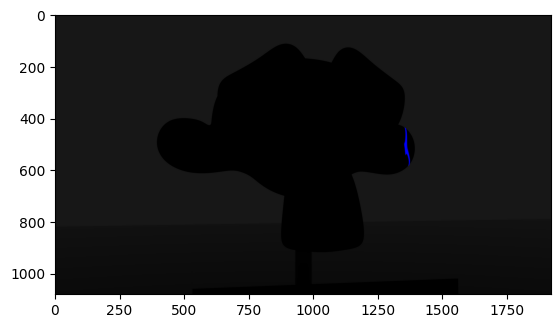

In [12]:
def redline_points(img):
    """
    get the points of the vertical redlines which are image points needed to calucalute epilines
    """
    # Convert to HSV (hue, saturation, value)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Define lower and upper limits of what we call "red"
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([10, 255, 255])
    # mask is a np array of (1080, 1920)
    mask = cv2.inRange(img_hsv, lower_red, upper_red)
    mask = np.clip(mask, 0, 255)
    return mask


def display_points(img,line):
    """
    just used to check if scan_lines() found the wright points from the readlines in the scanLeft and scanRight images
    """
    try:
        x1,y1,x2,y2 = line
        for y in range(y1,y2,15):
            cv2.circle(img,(x1,y),5,(0,255,0),-1)
    except Exception as e:
        print(e)

### Looping through each pair of images to get bluepoints coordinates

Finding left image blue points to compute correspoonding epiline in righ images


In [35]:
def redpoints_coordinates(img):
    # Isolate the red line
    redLine = redline_points(img)
    points = []
    for count, line in enumerate(redLine):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            # get the central pixel (for every lines with Red pixel in it) 
            # of the Red line by averaging over the coordinates 
            points.append([np.average(range(1920), weights = line), count])
        except:
            pass
    return points

pointsL = {} # to contain all images
pointsR = {}

for leftPath,rightPath in zip(scanRight,scanLeft): 
    imgL = cv2.imread(leftPath)
    imgR = cv2.imread(rightPath)
    Lpoints = redpoints_coordinates(imgL)
    Rpoints = redpoints_coordinates(imgR)
    if len(Lpoints)!=0:
        pointsL[leftPath] = Lpoints
    if len(Rpoints)!=0:
        pointsR[leftPath] = Rpoints
    



print(len(pointsL))
print(len(pointsR))



21
21


In [36]:
print(pointsL.keys())
print(pointsL["scanRight\scan0003.png"])

dict_keys(['scanRight\\scan0003.png', 'scanRight\\scan0004.png', 'scanRight\\scan0005.png', 'scanRight\\scan0006.png', 'scanRight\\scan0007.png', 'scanRight\\scan0008.png', 'scanRight\\scan0009.png', 'scanRight\\scan0010.png', 'scanRight\\scan0011.png', 'scanRight\\scan0012.png', 'scanRight\\scan0013.png', 'scanRight\\scan0014.png', 'scanRight\\scan0015.png', 'scanRight\\scan0016.png', 'scanRight\\scan0017.png', 'scanRight\\scan0018.png', 'scanRight\\scan0019.png', 'scanRight\\scan0020.png', 'scanRight\\scan0021.png', 'scanRight\\scan0022.png', 'scanRight\\scan0023.png'])
[[1497.0, 441], [1497.5, 442], [1498.0, 443], [1498.5, 444], [1498.5, 445], [1499.5, 446], [1500.0, 447], [1500.0, 448], [1500.5, 449], [1500.5, 450], [1500.5, 451], [1501.0, 452], [1501.0, 453], [1501.0, 454], [1501.0, 455], [1501.0, 456], [1501.0, 457], [1501.0, 458], [1501.0, 459], [1501.0, 460], [1501.0, 461], [1501.0, 462], [1501.0, 463], [1501.0, 464], [1501.0, 465], [1501.0, 466], [1501.0, 467], [1501.5, 468], 

### Drawing epilines for a single image

In [32]:
def compute_epiline(coords): # x_coords : coordonnée du point dans le plan image
    x,y = coords
    a,b,c = F @ (np.array([[x,y,1]]).transpose()) # 0 ou 1 ?
    return a,b,c

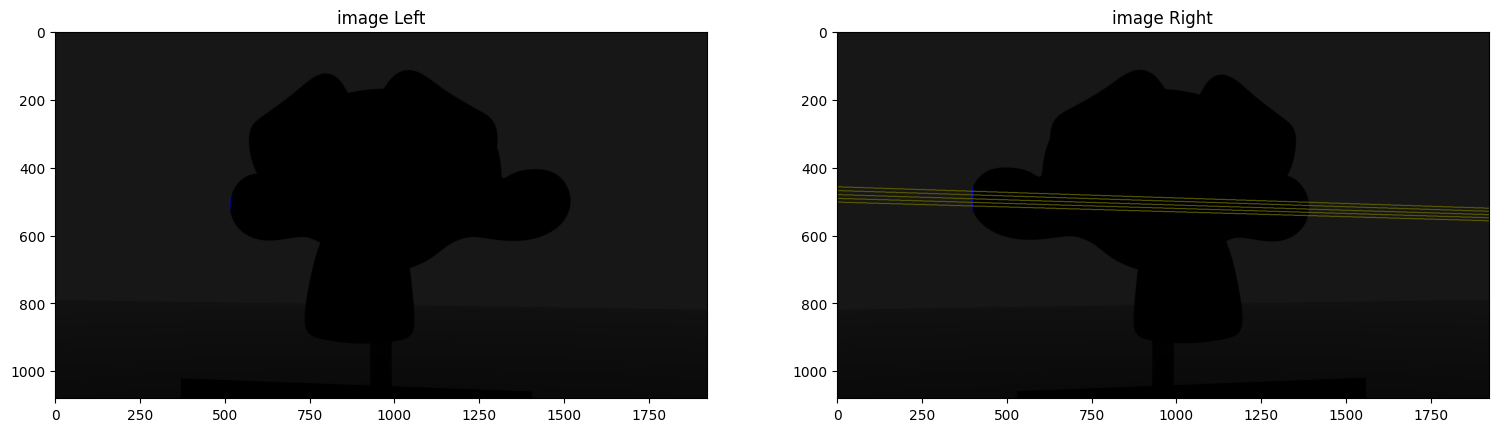

In [46]:
# print(len(RightImagesBluePoints))
i = 0
for lPath, rPath in zip(scanRight,scanLeft):
    i +=1
    if lPath in pointsL.keys():
        imgL = cv2.imread(lPath)
        imgR = cv2.imread(rPath)
        for i in range(0,len(pointsL[lPath]),10):
            a, b ,c = compute_epiline(pointsL[lPath][i])
            cv2.line(imgR, (0, -int(c/b)), (1920, -int((c+a*1920)/b)), (100,100, 0), 2)


    


fig, (ax1, ax2) = plt.subplots(1, 2)
# define the size of the figure
fig.set_size_inches(18.5, 10.5)
# cv2.circle(imgL,(1000,500),5,(0,255,0),-1)
# cv2.line(imgL, (0, -int(c/b)), (1920, -int((c+a*1920)/b)), (0, 255, 0), 2)
ax1.set_title("image Left")
ax1.imshow(imgL)
ax2.set_title("image Right")
ax2.imshow(imgR)

plt.show()

### Find corresponding points by intersection